## 5. 演習

1. Qiskitを使って、一般の サイモンの量子オラクルを実装して下さい。

2. シミュレーターまたは実機上で実装した サイモンの量子オラクルに対して、秘密ビット列 $b=1001$ をテストして下さい。結果が想定通りだったか確認し、どうしてそうなったか説明してみてください。


In [1]:
# Qiskit をインポートする
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

# 基本的なプロットツールをインポートする
from qiskit.visualization import plot_histogram

# Simonオラクルをインポートする
from qiskit_textbook.tools import simon_oracle


テキストの解説に従ってオラクルを構成する。

手順1. 1個目のレジスタの内容を2個目のレジスタにコピーします。 $$|x⟩|0⟩→|x⟩|x⟩$$

$\rightarrow$ これは、1個目のレジスタの各量子ビットごとに、2個目のレジスタの対応する量子ビットに対してCNOTをかけることで実現できる。


手順2. (1対1 または 2対1 写像を作る)もし $b$ が $0$ でない場合, $j$ ビットめの値が $b_j=1$ となる最も小さなインデックス $j$ が存在します。もし $x_j=0$ ならば、2個目のレジスターに $b$ に関して XOR を適用します。そうでなければ、何もしません。 $$|x⟩|x⟩→|x⟩|x\oplus b⟩ (もし x_j=0 ならば)$$

$\rightarrow$ ここで「$x_j=0$ ならば$b$ に関してXORを適用」する部分は、あらかじめ $x_j$ を反転させておいてから、$b$ をif文で判定してから $x_j$ を制御側とするCNOTを適用し、最後に $x_j$ の反転をもとに戻す、という処理を行うことにより実現できる。

手順3. (ランダムな置換を行う) 2個目のレジスターの量子ビットをランダムに置換します。 $$|x⟩|y⟩→|x⟩|f_b(y)⟩$$

$\rightarrow$ この置換は、ゼロ置換（何もしない）でもかまわない。

以上の考え方に基づいて、オラクルは以下のように構成できる。

In [2]:
def my_simon_oracle(b): 
    # n量子ビットのレジスタを2個準備
    n = len(b)
    qc = QuantumCircuit(2 * n)
    
    # 1個めのレジスタの内容を2個めのレジスタにコピー
    for i in range(n):
        qc.cx(i, i + n)
    qc.barrier()
    
    # b_j==1となる最小インデックスを取得
    index = b.find('1')
    
    # bがすべて0ならば何もせずに戻る
    if index < 0:
        return qc
    
    # x_indexをいったん反転する
    qc.x(index)
    
    # x_indexとb_iがともに1ならば第2レジスタの該当ビットを反転
    for i in range(n):
        if b[i] == '1':
            qc.cx(index, i + n)
    
    # 反転したx_indexをもとに戻す
    qc.x(index)
    
    return qc


上のオラクルを使用して、秘密ビット列 $b = 1001$ をテストする。
オラクルとしてmy_simon_oracleを使用する以外は、テキストと同じ。
ただし、テキストどおりにQuantumCircuitクラスに対して += 演算子を使用するとdeprecatedの警告が出る。
このため警告にしたがって、composeメソッドをinplaceオプション付きで使用するように変更した。

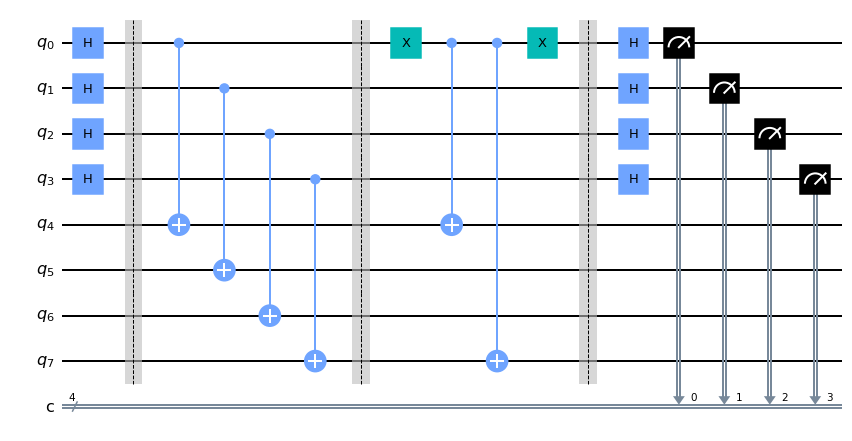

In [3]:
b = '1001'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# オラクルに入力する前にアダマールゲートを適用する
simon_circuit.h(range(n))    
    
# 可視性の向上のため、境界を挿入する
simon_circuit.barrier()

# +=演算子のDeprecationWarningを回避するため、composeメソッドをinplace=Trueで使用する
#simon_circuit += my_simon_oracle(b)
simon_circuit.compose(my_simon_oracle(b), inplace = True)

# 可視性の向上のため、境界を挿入する
simon_circuit.barrier()

# 入力レジスターにアダマールゲートを適用する
simon_circuit.h(range(n))

# 量子ビットを測定する
simon_circuit.measure(range(n), range(n))
simon_circuit.draw(output='mpl')


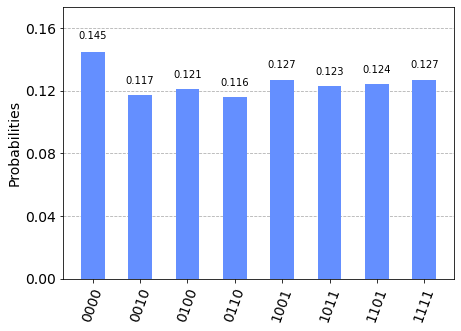

In [19]:
# ローカルシミュレーターを利用する
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(simon_circuit, backend=backend, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)


上のように、4ビット数値が取りうる16種類の可能性のうち、8種類の $z$ が求められる。

ビット列 $b=1001$ をこの $z$ で検証すると、次のように8種類全てで $b⋅z=0$ $(\mod 2)$ が成り立つことがわかる。

In [28]:
# 8つの z の出力とのドット内積を計算し検証する
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in sorted(counts.items()):
    print( '{}.{} = {} (mod 2)'.format(b, z[0], bdotz(b,z[0])) )


1001.0000 = 0 (mod 2)
1001.0010 = 0 (mod 2)
1001.0100 = 0 (mod 2)
1001.0110 = 0 (mod 2)
1001.1001 = 0 (mod 2)
1001.1011 = 0 (mod 2)
1001.1101 = 0 (mod 2)
1001.1111 = 0 (mod 2)


この計算結果から、以下のように $b = b_3b_2b_1b_0$ の値を推論することができる。

2番目の式 $b⋅0010=0$ から $b_1=0$ がわかる。

3番目の式 $b⋅0100=0$ から $b_2=0$ がわかる。

5番目の式 $b⋅1001=0$ から $b_0=b_3$ がわかる。

以上の結果は、残りの式と矛盾しない。

したがって、$b = 0000$ または $b = 1001$ のいずれか。

このうち、$b = 0000$ は自明な解で、この場合 $f$ は1対1対応関数となる。$b=1001$ は自明でない解で、この場合 $f$ は 2対1対応となる。